# Analysis of Drug Shortage database

The data we are using for our analysis contains historical data from 2017 to present. All these records has been reported by the Food and Drug Regulations require drug to sellers are not able to meet demand for a product or when they stop selling a product.

Shortage reports have 3 different stages and can be resolved as shown below

# ![image](Shortage_stages.jpg)

In [18]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
# import xlrd
import warnings
# import matplotlib.pyplot as plt
# import seaborn as sns
from prophet import Prophet
warnings.filterwarnings('ignore')

In [19]:
# Load updated shorage database
df = pd.read_csv("Shortage data/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# converting drugsname in lowercase
df['common_or_proper_name'] = df['common_or_proper_name'].str.lower()

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2017 for End_date
df = df.loc[(df['actual_end_date'] >= '2017-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

# Removing Avoided shortages (outliers for our analysis)
df = df[df['shortage_status']!="Avoided shortage"]

# Removing duplicates reports
df=df.drop_duplicates("report_id", keep=False)

# converting into datatime critical field
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

# Fill null DIN with zero, convering into integer
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

# calculating # of days of shortages
df['Days']= df['actual_end_date']-df['actual_start_date']

# Create clear field number of days as integer
df['Days2'] = df['Days'].dt.days
df['Days2']=df['Days2'].astype('int')


df.tail()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3,Days,Days2
17163,21685,2340445,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,zyclara,IMIQUIMOD,3.75%,na,TOPICAL,...,NaN,2017-09-08,2017-09-22,2017-09-22,Other (Please describe in comments),2017-09-08,2017-09-25,No,14 days,14
17164,52702,2340445,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,zyclara,IMIQUIMOD,3.75%,7.5g pump,TOPICAL,...,NaN,2019-04-01,NaN,2019-07-12,Other (Please describe in comments),2018-06-20,2019-07-13,No,102 days,102
17165,18241,2257270,Shortage,ZYMAR,ALLERGAN INC,zymar 1ml,GATIFLOXACIN,0.3%,1 mL,OPHTHALMIC,...,2017-08-03,2017-08-03,2017-09-18,2017-10-06,Disruption of the manufacture of the drug.,2017-08-03,2017-10-13,No,64 days,64
17166,33440,2257270,Shortage,ZYMAR,ALLERGAN INC,zymar 1ml,GATIFLOXACIN,0.3%,5mL,OPHTHALMIC,...,2019-09-16,2019-09-16,2019-09-20,2019-09-18,Disruption of the manufacture of the drug.,2017-12-18,2019-09-19,No,2 days,2
17167,54338,2243686,Shortage,ZYVOXAM,PFIZER CANADA INC,zyvoxam,LINEZOLID,3G,1x240ml Btl,ORAL,...,NaN,2018-08-21,NaN,2018-10-23,Disruption of the manufacture of the drug.,2018-07-04,2018-10-24,No,63 days,63


In [20]:
df.dtypes

report_id                               int64
drug_identification_number              int32
report_type                            object
brand_name                             object
company_name                           object
common_or_proper_name                  object
ingredients                            object
strength(s)                            object
packaging_size                         object
route_of_administration                object
shortage_status                        object
dosage_form(s)                         object
atc_code                               object
atc_description                        object
anticipated_start_date                 object
actual_start_date              datetime64[ns]
estimated_end_date                     object
actual_end_date                datetime64[ns]
reason                                 object
date_created                           object
date_updated                           object
tier_3                            

In [21]:
# Fill Nat end date with today date
# today = datetime.today().strftime('%Y-%m-%d')
# df = df.fillna(today)

In [22]:
din = df['drug_identification_number'].mode()
din


0    717002
Name: drug_identification_number, dtype: int32

In [23]:
col_list = ['actual_start_date', 'Days']
df2 = df[col_list]
df2

,actual_start_date,Days
0,2023-01-09,35 days
1,2022-06-09,11 days
2,2022-10-01,60 days
3,2022-05-04,47 days
4,2022-02-01,93 days
...,...,...
17163,2017-09-08,14 days
17164,2019-04-01,102 days
17165,2017-08-03,64 days
17166,2019-09-16,2 days


In [24]:
df2.columns = ['ds', 'y']
df2['y'] = df2['y'].dt.days
df2.head()

,ds,y
0,2023-01-09,35
1,2022-06-09,11
2,2022-10-01,60
3,2022-05-04,47
4,2022-02-01,93


In [25]:
# Removing negative days
df2= df2[(df2['y']>=0)]
df2.y.min()

0

### Training the time series model

In [26]:
p = Prophet(interval_width=0.5, daily_seasonality=True)

Now train the model.

In [27]:
model = p.fit(df2)

14:48:43 - cmdstanpy - INFO - Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing


### Making predictions and evaluating performance

In [28]:
future = p.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
2066,2024-03-26
2067,2024-03-27
2068,2024-03-28
2069,2024-03-29
2070,2024-03-30


In [29]:
forecast_prediction = p.predict(future)
forecast_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,629.247248,328.933843,582.200498,629.247248,629.247248,-175.761421,-175.761421,-175.761421,-316.783712,...,156.521530,156.521530,156.521530,-15.499239,-15.499239,-15.499239,0.0,0.0,0.0,453.485827
1,2017-01-03,628.253380,137.458822,370.525401,628.253380,628.253380,-380.631610,-380.631610,-380.631610,-316.783712,...,-46.385918,-46.385918,-46.385918,-17.461979,-17.461979,-17.461979,0.0,0.0,0.0,247.621770
2,2017-01-04,627.756446,144.177645,379.330582,627.756446,627.756446,-369.231329,-369.231329,-369.231329,-316.783712,...,-34.231471,-34.231471,-34.231471,-18.216146,-18.216146,-18.216146,0.0,0.0,0.0,258.525117
3,2017-01-06,626.762578,132.524654,384.120564,626.762578,626.762578,-374.604379,-374.604379,-374.604379,-316.783712,...,-38.551326,-38.551326,-38.551326,-19.269340,-19.269340,-19.269340,0.0,0.0,0.0,252.158199
4,2017-01-10,624.774842,105.088611,358.343059,624.774842,624.774842,-382.899709,-382.899709,-382.899709,-316.783712,...,-46.385918,-46.385918,-46.385918,-19.730079,-19.730079,-19.730079,0.0,0.0,0.0,241.875133


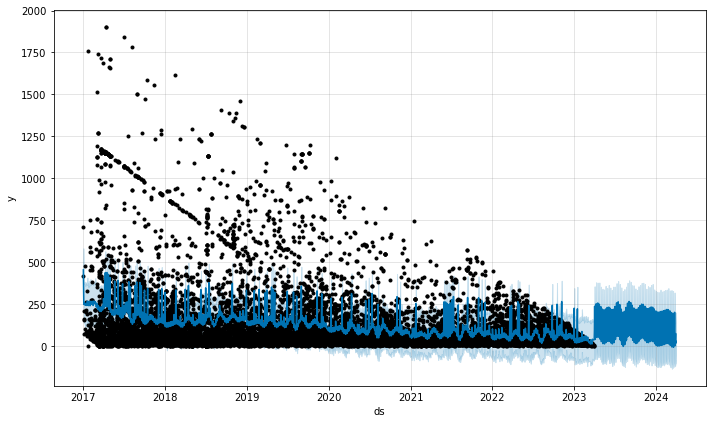

In [30]:
plot1 = p.plot(forecast_prediction)

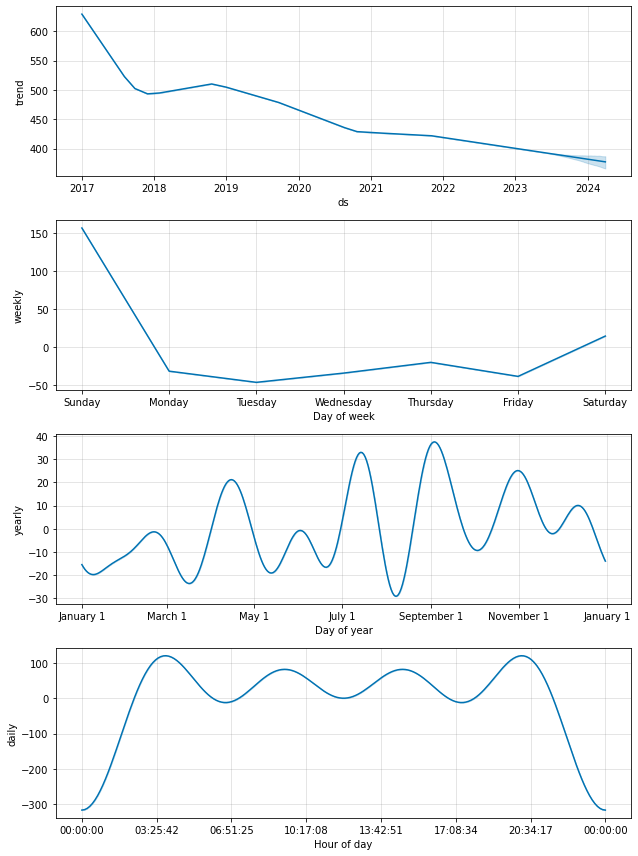

In [31]:
plot2 = p.plot_components(forecast_prediction)

(0.0, 498.8344100707148)

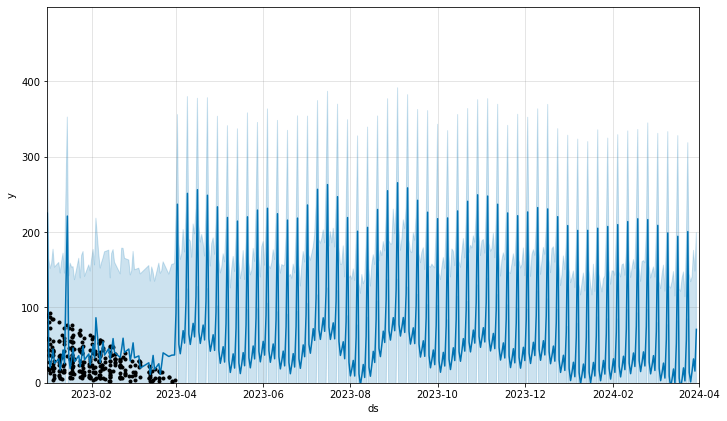

In [32]:
fig = p.plot(forecast_prediction)
ax = fig.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2023-01-01', '2024-04-01'])) 
ax.set_ylim([0, forecast_prediction.yhat.max()*1.1]) 